## Long Term Memory - Memory Store

Storing the Memory of the users for long term using the Langgraph Store API

LangGraph stores long-term memories as JSON documents in a store. Each memory is organized under a custom namespace (similar to a folder) and a distinct key (like a file name). Namespaces often include user or org IDs or other labels that makes it easier to organize information.

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from langgraph.store.sqlite import SqliteStore
from langgraph.store.base import BaseStore

Create the Store with Sqlite

In [2]:
import sqlite3
from sqlite3 import Connection

connection: Connection = sqlite3.connect("store.db",check_same_thread=False,isolation_level=None)
# Initialize the SQLite store
store= SqliteStore(connection)

When storing objects (e.g., memories) in the Store, we provide:

- The namespace for the object, a tuple (similar to directories)
- the object key (similar to filenames)
- the object value (similar to file contents)

We use the put method to save an object to the store by namespace and key.

In [3]:
user_id = '12'
namespace_for_memory = (
    user_id,
    "chat_memory",
)  # Tuple representing user-specific namespace
key = "conversation_1"  # Unique key for storing in the store
value = {"food": "Pizza", "name": "John Doe"}  # Data to be stored

Store in the database

In [4]:
store.put(namespace_for_memory,key,value)

Searching or getting the list of the namespace present in the store

In [5]:
store.get(namespace_for_memory,key)

Item(namespace=['12', 'chat_memory'], key='conversation_1', value={'food': 'Pizza', 'name': 'John Doe'}, created_at='2025-12-02T01:03:49', updated_at='2025-12-02T01:03:49')

List the Namespaces

In [6]:
store.list_namespaces()

[('1', 'chat_memory'), ('12', 'chat_memory')]

Search the values 

In [7]:
store.search(namespace_for_memory,query="food")

[Item(namespace=['12', 'chat_memory'], key='conversation_1', value={'food': 'Pizza', 'name': 'John Doe'}, created_at='2025-12-02T01:03:49', updated_at='2025-12-02T01:03:49', score=None)]

### Chatbot with Long-Term Memory

Creating the Instance of the LLM Model

In [8]:
llm_model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", temperature=0, include_thoughts=False
)

Creating the simple Converstation Chatbot

In [9]:
system_prompt_assistant="""
You are a helpful assistant that helps users with their questions. If you have the details or memory regarding the user, use that to answer the question.
Here is the Memory: {memory}
"""


system_prompt_gather="""
You are an assistant that helps gather information about the user to store in memory, For Personalizing the user experience.
Current User Information: {memory}
Based on the Chat History, extract the informmation like the below
INSTRUCTIONS:
1. Review the Chat History Carefully.
2. Identify any new information about the user that can be added to the memory, apart from the provided memory. 
3. format the memory as list of pairs.
4. If no new information is found, return the existing memory as is.
"""

In [10]:
from langgraph.graph import MessagesState
from langchain_core.runnables import RunnableConfig
from langchain.messages import SystemMessage


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["userid"]

    # Retrieve the memory from the store
    namespace_for_memory = (
        user_id,
        "chat_memory",
    )
    key = f"memory"
    existing_memory = store.get(namespace_for_memory, key)
    if existing_memory:
        memory_str = existing_memory.value.get("memory")
    else:
        memory_str = "No prior memory found."

    prompt_template = system_prompt_assistant.format(memory=memory_str)
    response = llm_model.invoke(
        [SystemMessage(content=prompt_template)] + state["messages"]
    )
    return {"messages": response}

In [11]:
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["userid"]

    # Retrieve the memory from the store
    namespace_for_memory = (
        user_id,
        "chat_memory",
    )
    key = f"memory"
    existing_memory = store.get(namespace_for_memory, key)
    if existing_memory:
        memory_str = existing_memory.value.get("memory")
    else:
        memory_str = "No prior memory found."

    prompt_template = system_prompt_gather.format(memory=memory_str)
    response = llm_model.invoke(
        [SystemMessage(content=prompt_template)] + state["messages"]
    )
    print(response.content)
    store.put(namespace_for_memory,key,{"memory": response.content})

Creating the graph

In [12]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

graph = StateGraph(MessagesState)
graph.add_node("call_model", call_model)
graph.add_node("write_memory", write_memory)

graph.add_edge(START, "call_model")
graph.add_edge("call_model", "write_memory")
graph.add_edge("write_memory", END)

# Passing the Store
compiled_graph = graph.compile(store=store, checkpointer=memory)

Display the graph

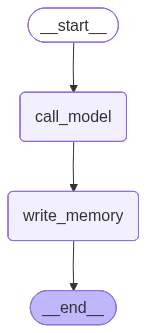

In [13]:
from IPython.display import display,Image

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

Let's test out these how it works. 

In [14]:
from langchain.messages import HumanMessage

config = {"configurable": {"thread_id": "1", "userid": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi Lance, it's great to meet you! I've got your name down. How can I help you today?
```json
[
    ["name", "Lance"]
]
```


Let's Check what is stored in the Store

In [37]:
store.list_namespaces()

[('1', 'chat_memory'), ('12', 'chat_memory')]

In [38]:
config = {"configurable": {"thread_id": "1", "userid": "1"}}

# User input 
input_messages = [HumanMessage(content="I Stays in the Europe for Study Purposes")]

# Run the graph
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I Stays in the Europe for Study Purposes
================================== Ai Message ==================================

That's interesting, Lance! Studying in Europe sounds like a great experience. Which country are you studying in, if you don't mind me asking? And what are you studying?


In [40]:
store.get(('1', 'chat_memory'),"memory")

Item(namespace=['1', 'chat_memory'], key='memory', value={'memory': ''}, created_at='2025-12-02T00:57:04', updated_at='2025-12-02T00:57:04')